<a href="https://colab.research.google.com/github/FrancescoI/RecoUtils/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pandas as pd
import numpy as np
from torch.autograd import Variable
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder

In [3]:
def gpu(tensor, gpu=False):

    if gpu:
        return tensor.cuda()
    else:
        return tensor


def cpu(tensor):

    if tensor.is_cuda:
        return tensor.cpu()
    else:
        return tensor

In [4]:
### Loss

In [5]:
def hinge_loss(positive, negative):
    
    loss = torch.clamp(negative - positive + 1.0, 0.0)

    return loss.mean()

In [6]:
### Utilities

In [7]:
def get_negative_batch(batch, n_items, item_to_metadata_dict):
    
    neg_batch = None

    neg_item_id = np.random.randint(0, n_items-1, len(batch))
    
    if item_to_metadata_dict:
        neg_metadata_id = [item_to_metadata_dict[item] for item in neg_item_id]    
    else:
        neg_metadata_id = None
    
    neg_batch = pd.concat([neg_batch, pd.DataFrame({'user_id': batch['user_id'],
                                                    'item_id': neg_item_id, 
                                                    'metadata': neg_metadata_id})])
            
    return neg_batch

In [8]:
class Dataset():
    
    def __init__(self, brand):
        
        self.brand = brand
    
    def _get_interactions(self):

        bucket_uri = f'/content/drive/My Drive/'

        if self.brand == 'missoni':
        
          dataset = pd.read_csv(bucket_uri + f'{self.brand}.csv')


        elif self.brand == 'ton':
          
          clickstream = pd.read_csv(bucket_uri + f'{self.brand}.csv')
          metadata = pd.read_csv(bucket_uri + 'anagrafica_ton.csv')

          clickstream = (clickstream\
                         .groupby(['user_ids', 'product_code'])['brand'].count() 
                         ).reset_index()
          
          clickstream.columns = ['hashedEmail', 'product', 'actions']

          dataset = pd.merge(clickstream, metadata, left_on='product', right_on='pty_pim_variant')
          
          dataset = dataset[['hashedEmail', 'product', 'macro', 'saleline', 'actions']]
          dataset.columns = ['hashedEmail', 'product', 'macro', 'saleLine', 'actions']

          dataset['gender'] = 'W'

        return dataset 
    
    
    def _encondig_label(self, dataset, input_col, output_col):
        
        encoder = LabelEncoder()
        dataset[output_col] = encoder.fit(dataset[input_col]).transform(dataset[input_col])
        
        return dataset, encoder
    
    
    def fit(self, metadata=None, seasons=None):
        
        dataset = self._get_interactions()
        self.metadata = metadata
        
        if seasons:
            dataset = dataset[dataset['season'].isin(seasons)]
        
        ### Label Encoding
        dataset, _ = self._encondig_label(dataset, input_col='hashedEmail', output_col='user_id')
        dataset, _ = self._encondig_label(dataset, input_col='product', output_col='item_id')
        
        if metadata is not None:
            output_list_name = []
            
            for meta in metadata:
                output_name = meta + '_id'
                dataset, _ = self._encondig_label(dataset, input_col=meta, output_col=output_name)
                output_list_name.append(output_name)                
            
            dataset['metadata'] = dataset[output_list_name].values.tolist()
            self.metadata_id = output_list_name
            
        self.dataset = dataset
        
    def get_item_metadata_dict(self):
        
        if self.metadata is not None:
        
            return self.dataset.set_index('item_id')['metadata'].to_dict()
        
        else:
            
            return None

In [9]:
### Evaluate

In [10]:
def auc_score(positive, negative):
    
    total_auc = []
    
    positive = positive.cpu().detach().numpy()
    negative = negative.cpu().detach().numpy()

    batch_auc = (positive > negative).sum() / len(positive)
    total_auc.append(batch_auc)
        
    return np.mean(total_auc)

In [11]:
def evaluate(model):
    
    ### TRAIN    
    negative_train = get_negative_batch(batch=model.train, n_items=model.dataset.dataset['item_id'].max(), item_to_metadata_dict=None)
    negative_train.columns = ['user_id', 'item_id_neg', 'metadata_neg']
    
    merged_train = pd.concat([model.train, negative_train], axis=1)
    
    train_auc = []
    
    for row in merged_train.itertuples():
        
        score = np.sum(model.pred[row.user_id, row.item_id] > model.pred[row.user_id, row.item_id_neg])
        train_auc.append(score)
    
    ### TEST
    negative_test = get_negative_batch(batch=model.test, n_items=model.dataset.dataset['item_id'].max(), item_to_metadata_dict=None)
    negative_test.columns = ['user_id', 'item_id_neg', 'metadata_neg']
    merged_test = pd.concat([model.test, negative_test], axis=1)
    
    test_auc = []
    
    for row in merged_test.itertuples():
        
        score = np.sum(model.pred[row.user_id, row.item_id] > model.pred[row.user_id, row.item_id_neg])
        test_auc.append(score)
    
    print(f'Train AUC: {np.sum(train_auc) / merged_train.shape[0]}')
    print(f'Test AUC: {np.sum(test_auc) / merged_test.shape[0]}')

In [12]:
def precision_recall_k(model, k):
    
    ### TRAIN
    values = np.ones(model.train.shape[0])
    users = model.train.loc[:, 'user_id']
    items = model.train.loc[:, 'item_id']
    
    sparse_matrix = sp.csr_matrix((values, (users, items)))
    
    matrix = sparse_matrix.toarray()
    total_precision = []
    total_recall = []
    
    for index, row in enumerate(matrix):
        
        truth = np.nonzero(row)[0]
        if len(truth) > 0:
            prediction = np.argsort(-model.pred[index, :])[:k]

            n_matching = len(set(truth) & set(prediction))
            precision = n_matching / k
            recall = n_matching / len(truth)

            total_precision.append(precision)
            total_recall.append(recall)
        
    print(f'Train Precision@{k}: {np.mean(total_precision)} \nTrain Recall@{k}: {np.mean(total_recall)} \nTrain Shape: {sparse_matrix.getnnz()}')
        
    
    ### TEST
    values = np.ones(model.test.shape[0])
    users = model.test.loc[:, 'user_id']
    items = model.test.loc[:, 'item_id']
    
    sparse_matrix = sp.csr_matrix((values, (users, items)))
    
    matrix = sparse_matrix.toarray()
    total_precision = []
    total_recall = []
    
    for index, row in enumerate(matrix):
        
        truth = np.nonzero(row)[0]
        if len(truth) > 0:
            prediction = np.argsort(-model.pred[index, :])[:k]

            n_matching = len(set(truth) & set(prediction))
            precision = n_matching / k
            recall = n_matching / len(truth)

            total_precision.append(precision)
            total_recall.append(recall)
        
    print(f'\nTest Precision@{k}: {np.mean(total_precision)} \nTest Recall@{k}: {np.mean(total_recall)} \nTest Shape: {sparse_matrix.getnnz()}')

In [13]:
### Model

In [14]:
class ScaledEmbedding(torch.nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [15]:
class ZeroEmbedding(torch.nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [16]:
class Miner(torch.nn.Module):
    
    def __init__(self, dataset, n_factors, net_type, use_metadata, use_cuda=False):
        super().__init__()
             
        self.dataset = dataset
        self.n_users = dataset.dataset['user_id'].max() + 1
        self.n_items = dataset.dataset['item_id'].max() + 1
        self.dictionary = dataset.get_item_metadata_dict()
        self.n_metadata = self._get_n_metadata(self.dataset)
        
        self.n_factors = n_factors
        
        self.use_cuda = use_cuda

        self.net_type = net_type
        self.use_metadata = use_metadata

        self._init_net(net_type=net_type)

    
    def _get_n_metadata(self, dataset):
        
        n_metadata = 0
        
        for col in dataset.metadata_id:
            n_metadata += dataset.dataset[col].max() + 1
        
        return n_metadata

    
    def _init_net(self, net_type='lightfm'):

        if net_type == 'lightfm':
          print('Training LightFM')
          self.net = LightFM(n_users=self.n_users, 
                              n_items=self.n_items, 
                              n_metadata=self.n_metadata, 
                              n_factors=self.n_factors, 
                              use_metadata=self.use_metadata, 
                              use_cuda=self.use_cuda)
        else:
          print('under_construction')
          #net = MLP(n_users, n_items, n_metadata, n_metadata_type, n_factors, use_metadata=True, use_cuda=False)
        

    def forward(self, net, batch, batch_size):

        score = gpu(net.forward(batch, batch_size), self.use_cuda)

        return score
    
    
    def backward(self, positive, negative, optimizer):
                
        optimizer.zero_grad()
                
        loss_value = hinge_loss(positive, negative)                

        loss_value.backward()
        
        optimizer.step()
        
        return loss_value.item()
    
    
    def fit(self, optimizer, batch_size=1024, epochs=10, split_train_test=False, verbose=False):
        
        if split_train_test:
            
            print('|== Splitting Train/Test ==|')
            
            data = self.dataset.dataset.iloc[np.random.permutation(len(self.dataset.dataset))]
            train = data.iloc[:int(len(data) * 0.9)]
            test = data.iloc[int(len(data) * 0.9):]
            
            print(f'Shape Train: {len(train)} \nShape Test: {len(test)}')
            
        else:
            
            train = self.dataset.dataset
        
        
        self.total_train_auc = []
        self.total_test_auc = []
        self.total_loss = []


        for epoch in range(epochs):

            print(f'Epoch: {epoch+1}')
            
            epoch_loss = []

            for first in range(0, len(train), batch_size):
                
                batch = train.iloc[first:first+batch_size, :]
                
                positive = self.forward(net=self.net, batch=batch, batch_size=batch_size)

                neg_batch = get_negative_batch(batch, self.n_items, self.dictionary)
                negative = self.forward(net=self.net, batch=neg_batch, batch_size=batch_size)     
                                                                
                loss_value = self.backward(positive, negative, optimizer)
                
            epoch_loss.append(loss_value)
            self.total_loss.append(epoch_loss)
            
            
            if verbose:
                ### AUC Calc.
                ### Train
                train_sample = train.sample(n=20_000)

                positive_train = self.forward(net=self.net, batch=train_sample, batch_size=len(train_sample))

                neg_batch = get_negative_batch(train_sample, self.n_items, self.dictionary)  
                negative_train = self.forward(net=self.net, batch=neg_batch, batch_size=len(train_sample))           
                
                train_auc = auc_score(positive_train, negative_train)
                self.total_train_auc.append(train_auc)
                
                ### Test
                test_sample = test.sample(n=20_000) 
                
                positive_test = self.forward(net=self.net, batch=test_sample, batch_size=len(test_sample))

                neg_batch = get_negative_batch(test_sample, self.n_items, self.dictionary)
                negative_test = self.forward(net=self.net, batch=neg_batch, batch_size=len(test_sample))   

                test_auc = auc_score(positive_test, negative_test)
                self.total_test_auc.append(test_auc)
                
                print(f'== Loss: {sum(epoch_loss)} \n== Train AUC: {train_auc} \n== Test AUC: {test_auc}')
            
    def history(self):
        
        return {'train_loss': self.total_loss,
                'train_auc': self.total_train_auc,
                'test_auc': self.total_test_auc}
    
    def get_item_representation(self):
        
        return self.item.weight.cpu().detach().numpy()

In [17]:
class LightFM(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_metadata, n_factors, use_metadata=True, use_cuda=False):
        super(LightFM, self).__init__()

        self.n_users = n_users
        self.n_items = n_items
        self.n_metadata = n_metadata
        
        self.n_factors = n_factors
        
        self.use_metadata = use_metadata
        self.use_cuda = use_cuda
        
        if use_metadata:
            self.n_metadata = self.n_metadata
            self.metadata = gpu(ScaledEmbedding(self.n_metadata, n_factors), self.use_cuda)

        
        self.user = gpu(ScaledEmbedding(self.n_users, self.n_factors), self.use_cuda)
        self.item = gpu(ScaledEmbedding(self.n_items, self.n_factors), self.use_cuda)
        
        self.user_bias = gpu(ZeroEmbedding(self.n_users, 1), self.use_cuda)
        self.item_bias = gpu(ZeroEmbedding(self.n_items, 1), self.use_cuda)
    
    
    def forward(self, batch, batch_size):
        
        """
        Forward method that express the model as the dot product of user and item embeddings, plus the biases. 
        Item Embeddings itself is the sum of the embeddings of the item ID and its metadata
        """
        
        user = Variable(gpu(torch.LongTensor(batch['user_id'].values), self.use_cuda))
        item = Variable(gpu(torch.LongTensor(batch['item_id'].values), self.use_cuda))
        
        if self.use_metadata:
            metadata = Variable(gpu(torch.LongTensor(list(batch['metadata'])), self.use_cuda))
            metadata = self.metadata(metadata)

        user_bias = self.user_bias(user)
        item_bias = self.item_bias(item)
        
        user = self.user(user)
        item = self.item(item)
        
        if self.use_metadata:
        
            ### Reshaping in order to match metadata tensor
            item = item.reshape(len(batch['item_id'].values), 1, self.n_factors)        
            item_metadata = torch.cat([item, metadata], axis=1)

            ### sum of latent dimensions
            item = item_metadata.sum(1)
        
        net = (user * item).sum(1).view(-1,1) + user_bias + item_bias
        
        return net
    
    def get_item_representation(self):
        
        if self.use_metadata:
            
            data = (self.dataset
                    .dataset[['item_id'] + self.dataset.metadata_id]
                    .drop_duplicates())
            
            mapping = pd.get_dummies(data, columns=[*self.dataset.metadata_id]).values[:, 1:]
            identity = np.identity(self.dataset.dataset['item_id'].max() + 1)
            binary = np.hstack([identity, mapping])
            
            metadata_representation = np.vstack([self.item.weight.detach().numpy(), self.metadata.weight.detach().numpy()])
            
            return np.dot(binary, metadata_representation), binary, metadata_representation
        
        else:
            return self.item.weight.cpu().detach().numpy()
        
        
    def predict(self, user_idx):
        
        """
        It takes a user vector representation (based on user_idx arg) and it takes the dot product with
        the item representation
        """
        
        item_repr, _, _ = self.get_item_representation()
        user_repr = self.user.weight.detach().numpy()
        
        item_bias = self.item_bias.weight.detach().numpy()
        user_bias = self.user_bias[torch.tensor([user_idx])].detach().numpy()
        
        return np.dot(user_pred[user_idx, :], item_repr) + item_bias + user_bias

In [18]:
class MLP(torch.nn.Module):

    ### UNDER COSTRUCTION
    
    def __init__(self, n_users, n_items, n_metadata, n_metadata_type, n_factors, use_metadata=True, use_cuda=False):
        super(MLP, self).__init__()
        
        self.use_metadata = use_metadata
        self.use_cuda = use_cuda

        if use_metadata:
            self.n_metadata = n_metadata
            self.n_metadata_type = n_metadata_type
            self.metadata = gpu(ScaledEmbedding(self.n_metadata, n_factors), self.use_cuda)
            
        else:
            self.n_metadata_type = 0
        
        self.linear_1 = gpu(torch.nn.Linear(n_factors*(2+self.n_metadata_type), int(self.n_factors/2)), self.use_cuda)
        self.linear_2 = gpu(torch.nn.Linear(int(self.n_factors/2), int(self.n_factors/4)), self.use_cuda)
        self.linear_3 = gpu(torch.nn.Linear(int(self.n_factors/4), 1), self.use_cuda)
        
    def _get_n_metadata(self, dataset):
        
        n_metadata = 0
        
        for col in dataset.metadata_id:
            n_metadata += dataset.dataset[col].max() + 1
        
        return n_metadata
    
    def _get_n_metadata_type(self, dataset):
        
        return len(dataset.metadata)
    
    
    def mlp(self, dataset, batch_size=1):
        
        """
        """
        user = gpu(torch.from_numpy(dataset['user_id'].values), self.use_cuda)
        item = gpu(torch.from_numpy(dataset['item_id'].values), self.use_cuda)
        
        if self.use_metadata:
            metadata = Variable(gpu(torch.LongTensor(list(dataset['metadata'])), self.use_cuda))
            metadata = self.metadata(metadata).reshape(batch_size, self.n_factors*self.n_metadata_type)
            
        user = self.user(user)
        item = self.item(item)
        
        if self.use_metadata:
            cat = torch.cat([user, item, metadata], axis=1).reshape(batch_size, (2+self.n_metadata_type)*self.n_factors)
        else:
            cat = torch.cat([user, item], axis=1).reshape(batch_size, 2*self.n_factors)
                
        net = self.linear_1(cat)
        net = torch.nn.functional.relu(net)
        
        net = self.linear_2(net)
        net = torch.nn.functional.relu(net)
        
        net = self.linear_3(net)
        
        return net
    
    def forward(self, dataset, batch_size=1):
        
        """
        """
        
        net = gpu(self.mlp(dataset, batch_size), self.use_cuda)
                
        return net
    
    def get_item_representation(self):
        
        if self.use_metadata:
            
            data = (self.dataset
                    .dataset[['item_id'] + self.dataset.metadata_id]
                    .drop_duplicates())
            
            mapping = pd.get_dummies(data, columns=[*self.dataset.metadata_id]).values[:, 1:]
            identity = np.identity(self.dataset.dataset['item_id'].max() + 1)
            binary = np.hstack([identity, mapping])
            
            metadata_representation = np.vstack([self.item.weight.detach().numpy(), self.metadata.weight.detach().numpy()])
            
            return np.dot(binary, metadata_representation), binary, metadata_representation
        
        else:
            return self.item.weight.cpu().detach().numpy()

In [20]:
class NeuCF(torch.nn.Module):
    
    def __init__(self, dataset, n_factors, use_metadata=True):
        super().__init__(dataset, n_factors)
        
        self.use_metadata = use_metadata
        
        if use_metadata:
            self.n_metadata = self._get_n_metadata(dataset)
            self.n_metadata_type = self._get_n_metadata_type(dataset)
            self.metadata_gmf = ScaledEmbedding(self.n_metadata, n_factors)
            self.metadata_mlp = ScaledEmbedding(self.n_metadata, n_factors)
            
        else:
            self.n_metadata_type = 0
    
        self.user_gmf = ScaledEmbedding(self.n_users, self.n_factors)
        self.user_mlp = ScaledEmbedding(self.n_users, self.n_factors)
        
        self.item_gmf = ScaledEmbedding(self.n_items, self.n_factors)
        self.item_mlp = ScaledEmbedding(self.n_items, self.n_factors)
        
        self.linear_1 = torch.nn.Linear(n_factors*(2+self.n_metadata_type), self.n_factors*4)
        self.linear_2 = torch.nn.Linear(self.n_factors*4, self.n_factors*2)
        self.linear_3 = torch.nn.Linear(self.n_factors*2, self.n_factors)
        self.linear_4 = torch.nn.Linear(self.n_factors*2, 1)
        
        self.weights = torch.nn.Parameter(torch.rand(2), requires_grad=True)
        
    def _get_n_metadata(self, dataset):
        
        n_metadata = 0
        
        for col in dataset.metadata_id:
            n_metadata += dataset.dataset[col].max() + 1
        
        return n_metadata
    
    def _get_n_metadata_type(self, dataset):
        
        return len(dataset.metadata)
    
        
    def gmf(self, dataset, batch_size=1):
        
        """
        """
        
        user = Variable(torch.LongTensor(dataset['user_id'].values))
        item = Variable(torch.LongTensor(dataset['item_id'].values))
        
        if self.use_metadata:
            metadata = Variable(torch.LongTensor(list(dataset['metadata'])))
            metadata = self.metadata_gmf(metadata)
            
        user = self.user_gmf(user)
        item = self.item_gmf(item)
        
        if self.use_metadata:
            item = item.reshape(batch_size, 1, self.n_factors)        
            item_metadata = torch.cat([item, metadata], axis=1)

            ### sum of latent dimensions
            item = item_metadata.sum(1)
        
        #net = (user * item).sum(1).view(-1,1) 
        net = (user * item)
        
        return net
    
    def mlp(self, dataset, batch_size=1):
        
        """
        """
        user = Variable(torch.LongTensor(dataset['user_id'].values))
        item = Variable(torch.LongTensor(dataset['item_id'].values))
        
        if self.use_metadata:
            metadata = Variable(torch.LongTensor(list(dataset['metadata'])))
            metadata = self.metadata_mlp(metadata).reshape(batch_size, self.n_factors*self.n_metadata_type)
            
        user = self.user_mlp(user)
        item = self.item_mlp(item)
        
        if self.use_metadata:
            cat = torch.cat([user, item, metadata], axis=1).reshape(batch_size, (2+self.n_metadata_type)*self.n_factors)
        else:
            cat = torch.cat([user, item], axis=1).reshape(batch_size, 2*self.n_factors)
                
        net = self.linear_1(cat)
        net = torch.nn.functional.relu(net)
        
        net = self.linear_2(net)
        net = torch.nn.functional.relu(net)
        
        net = self.linear_3(net)
        
        return net
    
    def forward(self, dataset, batch_size=1):
        
        """
        """
        user = Variable(torch.LongTensor(dataset['user_id'].values))
        item = Variable(torch.LongTensor(dataset['item_id'].values))
        
        gmf = self.gmf(dataset, batch_size)
        mlp = self.mlp(dataset, batch_size)
        
        net = torch.cat([gmf, mlp], axis=1)
        
        net = self.linear_4(net)
#        net = torch.nn.functional.sigmoid(net)
#         net = (self.weights * net).sum(1)
                
        return net

In [21]:
class EASE():
    
    def __init__(self, dataset, split_train_test=True):
        
        self.dataset = dataset
        self.item_dict = dataset.dataset.set_index('item_id')['product'].to_dict()
        self.split_train_test = split_train_test
        self._split_train_test()
        
    
    def _split_train_test(self):
        
        if self.split_train_test:
        
            print('|== Splitting Train/Test ==|')
            
            data = self.dataset.dataset.iloc[np.random.permutation(len(self.dataset.dataset))]
            self.train = data.iloc[:int(len(data) * 0.9)]
            self.test = data.iloc[int(len(data) * 0.9):]
            
            print(f'Shape Train: {len(self.train)} \nShape Test: {len(self.test)}')
            
        else:
            
            self.train = self.dataset.dataset
            
    
    def fit(self, lambda_: float = 0.5, implicit=True):
        
        if implicit:
            values = np.ones(self.train.shape[0])
        else:
            values = self.train.loc[:, 'action']
        
        users = self.train.loc[:, 'user_id']
        items = self.train.loc[:, 'item_id']
        
        matrix = sp.csr_matrix((values, (users, items)))
        self.matrix = matrix
        
        ### Weight Bij are
        ### 0s if i=j (diagonal)
        ### -Pij / Pjj otherwise
        ### where P = Xt * X - lambda*I
        
        g = matrix.T.dot(matrix).toarray() 
        
        diagonal = np.diag_indices(g.shape[0])
        g[diagonal] += lambda_ ### => gives P
        
        p = np.linalg.inv(g)
        
        b = p / (-np.diag(p)) ### => gives Bij
        b[diagonal] = 0       ### and sets diagonal to 0
        
        self.b = b
        self.pred = matrix.dot(b)
        
    
    def predict(self, user_id, k):
        
        user_prediction = self.pred[user_id, :]
        item_ranked = np.argsort(-user_prediction)[:k]
        
        item_ranked = [self.item_dict[item] for item in item_ranked]
        
        return item_ranked
    
    
    def get_similarity(self, k=10):
        
        similarity = {}
        
        for idx, row in enumerate(self.b):
            
            sorted_index = np.argsort(-row)[:k]
            sorted_codes = [self.item_dict[item] for item in sorted_index]
            similarity.update({self.item_dict[idx]: sorted_codes})
            
        return similarity

In [22]:
### Main

In [34]:
dataset = Dataset(brand='ton')
dataset.fit(metadata=['saleLine'])

In [57]:
config = {'model': ['lightfm'],
          'metadata': [True, False],
          'n_factors': [128, 64],
          'lr': [1e-2, 1e-3],
          'batch_size': [51_200]}

is_verbose=True
epochs=20

In [58]:
import datetime

In [59]:
performance = None
id = 0

for model in config['model']:
  for is_metadata in config['metadata']:
    for factors in config['n_factors']:
      for lr in config['lr']:
        for batch_size in config['batch_size']:

          print(f'Model: {model}, \nMetadata: {is_metadata}, \nFactors: {factors} \nLR: {lr}, \nBatch Size: {batch_size}')
          start = datetime.datetime.now()

          if model == 'lightfm':

            modello = Miner(dataset=dataset,
                            n_factors=factors,
                            use_metadata=is_metadata,
                            net_type='lightfm',
                            use_cuda=True)
            
          else: 

            modello = Miner(dataset=dataset,
                            n_factors=factors,
                            use_metadata=is_metadata,
                            net_type='mlp',
                            use_cuda=True)
                        
          optimizer_model = torch.optim.Adam(modello.net.parameters(), 
                                             lr=lr)
          
          modello.fit(optimizer=optimizer_model, 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      split_train_test=True,
                      verbose=is_verbose)
          
          end = datetime.datetime.now()
          runtime = (end - start).seconds

          print(f'\n Runtime: {runtime} \n')

          id += 1
          
          single = pd.DataFrame({'id': id,
                                'model': model,
                                'use_metadata': is_metadata,
                                'factors': factors,
                                'lr': [lr],
                                'batch_size': [batch_size],
                                'train_AUC': modello.history()['train_auc'][epochs-1],
                                'test_AUC': modello.history()['test_auc'][epochs-1],
                                'history_train_AUC': [modello.history()['train_auc']],
                                'history_test_AUC': [modello.history()['test_auc']],
                                'runtime': [runtime]})
          
          performance = pd.concat([performance, single])

Model: lightfm, 
Metadata: True, 
Factors: 128 
LR: 0.01, 
Batch Size: 51200
Training LightFM
|== Splitting Train/Test ==|
Shape Train: 6493380 
Shape Test: 721487
Epoch: 1
== Loss: 0.17334800958633423 
== Train AUC: 0.96865 
== Test AUC: 0.9346
Epoch: 2
== Loss: 0.06908554583787918 
== Train AUC: 0.98295 
== Test AUC: 0.9436
Epoch: 3
== Loss: 0.04899083450436592 
== Train AUC: 0.9861 
== Test AUC: 0.95035
Epoch: 4
== Loss: 0.04147815331816673 
== Train AUC: 0.9862 
== Test AUC: 0.95185
Epoch: 5
== Loss: 0.039015062153339386 
== Train AUC: 0.98735 
== Test AUC: 0.95095
Epoch: 6
== Loss: 0.03590443357825279 
== Train AUC: 0.98725 
== Test AUC: 0.95145
Epoch: 7
== Loss: 0.033245544880628586 
== Train AUC: 0.98745 
== Test AUC: 0.9514
Epoch: 8
== Loss: 0.03382667154073715 
== Train AUC: 0.9891 
== Test AUC: 0.94995
Epoch: 9
== Loss: 0.030395057052373886 
== Train AUC: 0.9905 
== Test AUC: 0.95405
Epoch: 10
== Loss: 0.03202332928776741 
== Train AUC: 0.9901 
== Test AUC: 0.95225
Epoch: 11


In [60]:
best_performing = performance.sort_values('test_AUC', ascending=False).head(4)

In [61]:
best_performing

,id,model,use_metadata,factors,lr,batch_size,train_AUC,test_AUC,history_train_AUC,history_test_AUC,runtime
0,6,lightfm,False,128,0.001,51200,0.99305,0.97155,"[0.84715, 0.88185, 0.91245, 0.9379, 0.9557, 0....","[0.83335, 0.86425, 0.8942, 0.91465, 0.93415, 0...",308
0,8,lightfm,False,64,0.001,51200,0.98805,0.96545,"[0.8353, 0.8554, 0.8774, 0.90695, 0.92775, 0.9...","[0.82645, 0.84415, 0.86155, 0.88645, 0.91165, ...",247
0,2,lightfm,True,128,0.001,51200,0.99325,0.96075,"[0.9223, 0.941, 0.9599, 0.97035, 0.97485, 0.97...","[0.8971, 0.91745, 0.9321, 0.9369, 0.94395, 0.9...",412
0,4,lightfm,True,64,0.001,51200,0.98910,0.95485,"[0.90155, 0.929, 0.9486, 0.95825, 0.96525, 0.9...","[0.88825, 0.9051, 0.91845, 0.92315, 0.93355, 0...",352


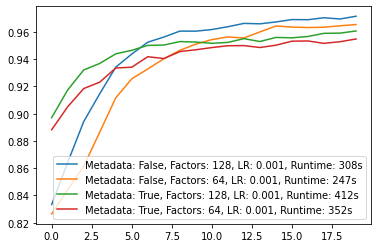

In [63]:
import matplotlib.pyplot as plt
for idx, row in best_performing.iterrows():
  plt.plot(range(20), row['history_test_AUC'], label=f"Metadata: {row['use_metadata']}, Factors: {row['factors']}, LR: {row['lr']}, Runtime: {row['runtime']}s")
  plt.legend()